## composite, non-linear rheology:


The viscous rheology in this model is similar to the Čížková and Bina paper cited below. Other parts of the model setup are similar to Arredondo and Billen (2016) and Korenaga (2011). 

Here we use a dimensionless system. For the psuedo-plastic effective rheology a Drucker-prager model is used.


**Keywords:** thermal covection, dislocation creep


**References**

Čížková, Hana, and Craig R. Bina. "Geodynamics of trench advance: Insights from a Philippine-Sea-style geometry." Earth and Planetary Science Letters 430 (2015): 408-415.

Arredondo, Katrina M., and Magali I. Billen. "The Effects of Phase Transitions and Compositional Layering in Two-dimensional Kinematic Models of Subduction." Journal of Geodynamics (2016).

Korenaga, Jun. "Scaling of plate tectonic convection with pseudoplastic rheology." Journal of Geophysical Research: Solid Earth 115.B11 (2010).

In [2]:
import numpy as np
import underworld as uw
import math
from underworld import function as fn
import glucifer

import os
import sys
import natsort
import shutil
from easydict import EasyDict as edict
import operator
import pint
import time
import operator
from slippy2 import boundary_layer2d
from slippy2 import material_graph
from slippy2 import spmesh

from mpi4py import MPI
comm = MPI.COMM_WORLD
rank = comm.Get_rank()

Model name and directories
-----

In [3]:
############
#Model name.  
############
Model = "T"
ModNum = 2

if len(sys.argv) == 1:
    ModIt = "Base"
elif sys.argv[1] == '-f':
    ModIt = "Base"
else:
    ModIt = str(sys.argv[1])

In [4]:
###########
#Standard output directory setup
###########


outputPath = "results" + "/" +  str(Model) + "/" + str(ModNum) + "/" + str(ModIt) + "/"
imagePath = outputPath + 'images/'
filePath = outputPath + 'files/'
checkpointPath = outputPath + 'checkpoint/'
dbPath = outputPath + 'gldbs/'
outputFile = 'results_model' + Model + '_' + str(ModNum) + '_' + str(ModIt) + '.dat'

if uw.rank()==0:
    # make directories if they don't exist
    if not os.path.isdir(outputPath):
        os.makedirs(outputPath)
    if not os.path.isdir(checkpointPath):
        os.makedirs(checkpointPath)
    if not os.path.isdir(imagePath):
        os.makedirs(imagePath)
    if not os.path.isdir(dbPath):
        os.makedirs(dbPath)
    if not os.path.isdir(filePath):
        os.makedirs(filePath)
        
comm.Barrier() #Barrier here so no procs run the check in the next cell too early

In [5]:
###########
#Check if starting from checkpoint
###########

checkdirs = []
for dirpath, dirnames, files in os.walk(checkpointPath):
    if files:
        print dirpath, 'has files'
        checkpointLoad = True
        checkdirs.append(dirpath)
    if not files:
        print dirpath, 'is empty'
        checkpointLoad = False

results/T/2/Base/checkpoint/ is empty


Setup parameters
-----

Set simulation parameters for test.

**Use pint to setup any unit conversions we'll need**

In [6]:
u = pint.UnitRegistry()
cmpery = 1.*u.cm/u.year
mpermy = 1.*u.m/u.megayear

cmpery.to(mpermy)

<Quantity(10000.0, 'meter / megayear')>

**Set parameter dictionaries**

In [27]:
#dimensional parameter dictionary
dp = edict({#'LS':2900.*1e3,
            'LS':2000.*1e3,
           'rho':3300,
           'g':9.8, 
           'eta0':4e20, #Dislocation creep at 250 km, 1573 K, 1e-15 s-1 
           'k':1e-6,
           'a':3e-5, #surface thermal expansivity
           'TP':1573., #potential temp
           'TS':273., #surface temp
           'cohesion':1e7, #
           'fc':0.06,        #This is the value from 
           'Adf':1e-9,
           'Ads':3.1e-17,
           'Edf':3.35e5,
           'Eds':4.8e5,
           'Vdf':4e-6,
           'Vds':11e-6,
           'Alm':1.3e-16,
           'Elm':2.0e5,
           'Vlm':1.1e-6,
           'Ba':4.3e-12,  #A value to simulate pressure increase with depth
           'SR':1e-15,
           'Dr':250e3, #Reference depth
           'n':3.5,
           'R':8.314,
           'Cp':1250., #Jkg-1K-1
           'StALS':100e3,
           'plate_vel':8})

#Adibatic heating stuff
dp.dTa = (dp.a*dp.g*(dp.TP))/dp.Cp #adibatic gradient, at Tp
dp.deltaTa = (dp.TP + dp.dTa*dp.LS) - dp.TS  #Adiabatic Temp at base of mantle, minus Ts
dp.deltaT = dp.deltaTa


#ndf = (1./dp.Adf)*np.exp( ((dp.Edf + dp.Vdf*dp.Pr))/((dp.R*dp.Tr)))
#nds = (1./dp.Ads**(1/dp.n))*(dp.SR**((1-dp.n)/dp.n))*np.exp( ((dp.Eds + dp.Vds*dp.Pr))/((dp.n*dp.R*dp.Tr)))


#scale_factors

sf = edict({'stress':dp.LS**2/(dp.k*dp.eta0),
            'lith_grad':dp.rho*dp.g*(dp.LS)**3/(dp.eta0*dp.k) ,
            'vel':dp.LS/dp.k,
            'SR':dp.LS**2/dp.k,
            'W':(-1./dp.Ba)*(np.log(1.-dp.rho*dp.g*dp.Ba*dp.LS))/(dp.R*dp.deltaTa), #Including adiabatic compression, and deltaTa
            'E': 1./(dp.R*dp.deltaTa), #using deltaTa, the guesstimated adiabatic temp differnnce to scale these paramters
            'Ads':(dp.eta0**(dp.n-2))*((dp.k)**(dp.n-1))*((dp.LS)**(2. - 2*dp.n))       })

#dimensionless parameters


ndp = edict({'RA':(dp.g*dp.rho*dp.a*dp.deltaT*(dp.LS)**3)/(dp.k*dp.eta0),
            'cohesion':dp.cohesion*sf.stress,
            'fcd':dp.fc*sf.lith_grad,
            'gamma':dp.fc/(dp.a*dp.deltaT),
            'Wdf':dp.Vdf*sf.W,
            'Edf':dp.Edf*sf.E,
            'Wds':dp.Vds*sf.W,
            'Eds':dp.Eds*sf.E,
            'Elm':dp.Elm*sf.E,
           'Wlm':dp.Vlm*sf.W,
            'TSP':0., 
            'TBP':1.,
            'TPP':(dp.TP - dp.TS)/dp.deltaT,
            'Dr':dp.Dr/dp.LS,
            'n':1.,
            'TS':dp.TS/dp.deltaT,
            'TP':dp.TP/dp.deltaT,
             #'eta_crust':1e21/dp.eta0,
             'eta_crust':1.,
            'eta_min':1e-3,
            'eta_max':1e5,
            'H':0.,
            'Tmvp':0.6,
             'Di': dp.a*dp.g*dp.LS/dp.Cp, #Dissipation number
            'Steta0':1e2,
            'plate_vel':sf.vel*dp.plate_vel*(cmpery.to(u.m/u.second)).magnitude,})




dp.VR = (0.1*(dp.k/dp.LS)*ndp.RA**(2/3.)) #characteristic velocity from a scaling relationship
dp.SR = dp.VR/dp.LS #characteristic strain rate
ndp.VR = dp.VR*sf.vel #characteristic velocity
ndp.SR = dp.SR*sf.SR #characteristic strain rate

ndp.StRA = (3300.*dp.g*(dp.LS)**3)/(dp.eta0 *dp.k) #Composisitional Rayleigh number for rock-air buoyancy force


ndp.TaP = 1. - ndp.TPP,  #Dimensionles adiabtic component of delta t

In [25]:
ndp.eta_crust

2.5

In [9]:
#(dp.g*dp.rho*dp.a*dp.deltaT*(dp.LS)**3)/(dp.k*1e6)
#sf.SR/(60*60*24*365*1e6)
#dp.LS**2/dp.k
#sf.SR
ndp.Edf,  ndp.Eds, ndp.Wdf, ndp.Wds, ndp.cohesion, ndp.RA

(19.75229500743525,
 28.301795831549015,
 17.875211307509375,
 49.15683109565078,
 100000.0,
 39582980.236800015)

In [10]:
#A few parameters defining lengths scales, affects materal transistions etc.
MANTLETOCRUST = (20.*1e3)/dp.LS #Crust depth
CRUSTTOMANTLE = (200.*1e3)/dp.LS
LITHTOMANTLE = (900.*1e3)/dp.LS 
MANTLETOLITH = (200.*1e3)/dp.LS 
TOPOHEIGHT = (10.*1e3)/dp.LS  #rock-air topography limits
CRUSTTOECL  = (100.*1e3)/dp.LS
AVGTEMP = ndp.TPP #Used to define lithosphere
LOWERMANTLE = (1000.*1e3)/dp.LS 


**Model setup parameters**

In [11]:
###########
#Model setup parameters
###########

refineMesh = True
stickyAir = False 
lower_mantle = False 
melt_viscosity_reduction= False




MINX = -2.
MINY = 0.
MAXX = 2.

#MAXY = 1.035
MAXY = 1.

if MINX == 0.:
    squareModel = True
else: 
    squareModel = False
    
    
dim = 2          # number of spatial dimensions


#MESH STUFF

RES = 92

Xres = int(RES*4)


if stickyAir:
    Yres = RES
    MAXY = 1. + dp.StALS/dp.LS #150km
    
else:
    Yres = RES
    MAXY = 1.


periodic = [False, False]
elementType = "Q1/dQ0"
#elementType ="Q2/DPC1"


#System/Solver stuff

PIC_integration=True
ppc = 25

#Output and safety stuff

swarm_repop, swarm_update = 10, 10
gldbs_output = 20
checkpoint_every, files_output = 50, 50
metric_output = 10
sticky_air_temp = 5

Create mesh and finite element variables
------

In [12]:
mesh = uw.mesh.FeMesh_Cartesian( elementType = (elementType),
                                 elementRes  = (Xres, Yres), 
                                 minCoord    = (MINX, MINY), 
                                 maxCoord    = (MAXX, MAXY), periodic=periodic)

velocityField       = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=2 )
pressureField       = uw.mesh.MeshVariable( mesh=mesh.subMesh, nodeDofCount=1 )
temperatureField    = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=1 )
temperatureDotField = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=1 )

In [13]:
axis = 1
orgs = np.linspace(mesh.minCoord[axis], mesh.maxCoord[axis], mesh.elementRes[axis] + 1)

value_to_constrain = 1.


yconst = [(spmesh.find_closest(orgs, value_to_constrain), np.array([value_to_constrain,0]))]

In [14]:
mesh.reset()

In [15]:
#Y-Axis
if refineMesh:
    #Y-Axis
    axis = 1
    origcoords = np.linspace(mesh.minCoord[axis], mesh.maxCoord[axis], mesh.elementRes[axis] + 1)
    edge_rest_lengths = np.diff(origcoords)

    deform_lengths = edge_rest_lengths.copy()
    min_point =  (mesh.maxCoord[axis])
    el_reduction = 0.6001
    dx = mesh.maxCoord[axis]

    deform_lengths = deform_lengths - \
                                    ((1.-el_reduction)*deform_lengths[0]) + \
                                    abs((origcoords[1:] - min_point))*((0.5*deform_lengths[0])/dx)

    #print(edge_rest_lengths.shape, deform_lengths.shape)

    spmesh.deform_1d(deform_lengths, mesh,axis = 'y',norm = 'Min', constraints = yconst)

Min
(92, 0.0065228260869565693, 0.84738260869565207, 0.61717802197803362)
('edges', 92)
-- iteration 0 --
| F( p_n ) |^2: 3.86187938314e-05
| p_n+1 - p_n |^2: 0.501259071
-- iteration 1 --
| F( p_n ) |^2: 4.35579149579e-31
Min, Max element width: 
0.00652
0.01522


Initial conditions
-------


In [16]:
coordinate = fn.input()
depthFn = 1. - coordinate[1]

In [17]:
#Work out actual temp at 200 km

potTempFn = ndp.TPP + (depthFn)*ndp.TaP

abHeatFn = -1.*velocityField[1]*temperatureField*ndp.Di

In [18]:
symmetric_IC = False
slab_IC = True


#Sinusoidal initial condition
A = 0.2
sinFn = depthFn + A*(fn.math.cos( math.pi * coordinate[0])  * fn.math.sin( math.pi * coordinate[1] ))        

#Initial Slab depth
iD = 660e3/dp.LS

#Boundary layer/slab initial condition
dl =  2*math.sqrt(dp.k*160e6*3600*24*365) #diffusion Length at ... My
w0 = dl/dp.LS
#w0 = 0.1
delX1 = fn.misc.min(fn.math.abs(coordinate[0] - -0.), fn.math.abs(coordinate[0] - -2.))
delX = fn.misc.min(delX1 , fn.math.abs(coordinate[0] - 2.))
w = w0*fn.math.sqrt(delX + 1e-7)
#tempBL = (ndp.TIP - ndp.TSP) *fn.math.erf((depthFn)/w) + ndp.TSP
tempBL = (potTempFn) *fn.math.erf((depthFn)/w) + ndp.TSP


delX = fn.misc.min(fn.math.abs(coordinate[0] - - 1.) , fn.math.abs(coordinate[0] - 1.))
#tempSlab = (ndp.TIP - ndp.TSP) *fn.math.erf((delX*2.)/w0) + ndp.TSP 
tempSlab = (potTempFn ) *fn.math.erf((delX*2.)/w0) + ndp.TSP       

tempFn1 =  fn.misc.min(tempBL, tempSlab)
blFn = fn.branching.conditional([(depthFn < iD, tempFn1), 
                                    (True, potTempFn)])

tempFn = 0.2*sinFn + 0.8*blFn #partition the temp between these two functions

if symmetric_IC:  
    if not checkpointLoad:
        temperatureField.data[:] = tempFn.evaluate(mesh)  

In [19]:
###########
#Boundary layer / slab paramaters
###########

dl =  2*math.sqrt(dp.k*160e6*3600*24*365) #diffusion Length at ... My
w0 = dl/dp.LS


ageFn = (fn.math.abs(fn.math.abs(coordinate[0]) - 2.)/2.)

ageFn  = fn.branching.conditional([(coordinate[0] <= 0, ageFn),
                                  (True, ageFn/3.)])

w = w0*fn.math.sqrt(ageFn + 1e-7)
#tempBL = (ndp.TIP - ndp.TSP) *fn.math.erf((depthFn)/w) + ndp.TSP
tempBL = (potTempFn) *fn.math.erf((depthFn)/w) + ndp.TSP

if slab_IC:
    if not checkpointLoad:
        temperatureField.data[:] = tempBL.evaluate(mesh) 



In [20]:
#Make sure material in stick air region is at the surface temperature.
for index, coord in enumerate(mesh.data):
            if coord[1] >= 1.:
                temperatureField.data[index] = ndp.TSP


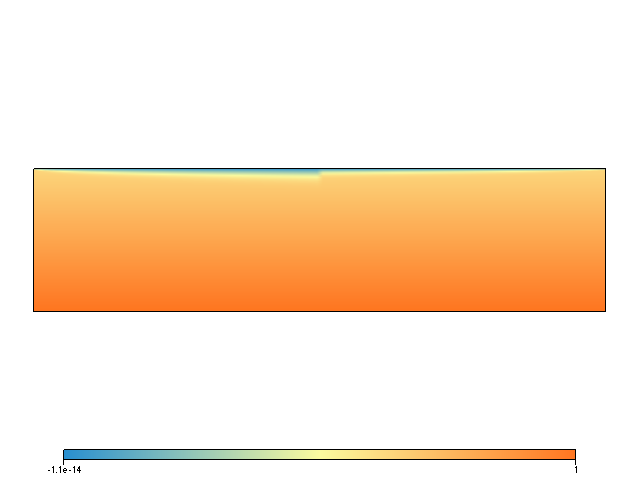

In [22]:
fig= glucifer.Figure()
fig.append( glucifer.objects.Surface(mesh, temperatureField))
fig.show()

In [23]:
#Slab perturbation paramaters
Roc = 550.
theta = 89.
subzone = 0.0

def inCircleFnGenerator(centre, radius):
    coord = fn.input()
    offsetFn = coord - centre
    return fn.math.dot( offsetFn, offsetFn ) < radius**2

#Setup slab perturbation params (mostly dimensionles / model params here)
phi = 90. - theta
RocM = (Roc/dp.LS)*1e3
CrustM = MANTLETOCRUST
#slabdepth = lithdepthfunc(agefunc(off, off, vel), dp.k)
#slabdepthM *= 5.
Org = (subzone, 1.-RocM)
#Use three circles to define our slab and crust perturbation,  

Oc = inCircleFnGenerator(Org , RocM)
Cc = inCircleFnGenerator(Org , RocM - 2.*CrustM) #Twice as wide as ordinary crust
dx = (RocM)/(np.math.tan((np.math.pi/180.)*phi))


#Work our which way the slab should face:
sense = 'Right'
#if lith.agefunc(subzone + 0.0001) < lith.agefunc(subzone - 0.0001):
#    sense = 'Right'

#We'll also create a triangle which will truncate the circles defining the slab...
if sense == 'Left': 
    ptx = subzone - dx
else:
    ptx = subzone + dx

coords = ((0.+subzone, 1), (0.+subzone, 1.-RocM), (ptx, 1.))
Tri = fn.shape.Polygon(np.array(coords))

**Boundary conditions**

In [22]:
for index in mesh.specialSets["MinJ_VertexSet"]:
    temperatureField.data[index] = ndp.TBP
for index in mesh.specialSets["MaxJ_VertexSet"]:
    temperatureField.data[index] = ndp.TSP
    
iWalls = mesh.specialSets["MinI_VertexSet"] + mesh.specialSets["MaxI_VertexSet"]
jWalls = mesh.specialSets["MinJ_VertexSet"] + mesh.specialSets["MaxJ_VertexSet"]
tWalls = mesh.specialSets["MaxJ_VertexSet"]
bWalls =mesh.specialSets["MinJ_VertexSet"]

VelBCs = mesh.specialSets["Empty"]
for index in list(tWalls.data):
    if (mesh.data[int(index)][0] < (subzone - 0.2) and mesh.data[int(index)][0] > -2 + 0.2): #Only push with a portion of teh overiding plate
        VelBCs.add(int(index))
        #Set the plate velocities for the kinematic phase
        velocityField.data[index] = [ndp.plate_vel, 0.]


freeslipBC = uw.conditions.DirichletCondition( variable      = velocityField, 
                                               indexSetsPerDof = ( iWalls + VelBCs, jWalls) )

#If periodic, we'll fix a the x-vel at a single node - at the bottom left (index 0)
Fixed = mesh.specialSets["Empty"]
Fixed.add(int(0))




if periodic[0] == True:
    freeslipBC = uw.conditions.DirichletCondition( variable      = velocityField, 
                                               indexSetsPerDof = ( Fixed + VelBCs , jWalls) )
    
    
    
# also set dirichlet for temp field
dirichTempBC = uw.conditions.DirichletCondition(     variable=temperatureField, 
                                              indexSetsPerDof=(tWalls,) )
dT_dy = [0.,0.]

# also set dirichlet for temp field
neumannTempBC = uw.conditions.NeumannCondition( dT_dy, variable=temperatureField, 
                                         nodeIndexSet=bWalls)



Particles
-----


In [23]:
###########
#Material Swarm and variables
###########


gSwarm = uw.swarm.Swarm(mesh=mesh, particleEscape=True)

yieldingCheck = gSwarm.add_variable( dataType="int", count=1 )
tracerVariable = gSwarm.add_variable( dataType="int", count=1)
materialVariable = gSwarm.add_variable( dataType="int", count=1 )
timeVariable = gSwarm.add_variable( dataType="float", count=1 )




In [24]:
varlist = [tracerVariable, tracerVariable, yieldingCheck]

varlist = [materialVariable, yieldingCheck, timeVariable]
varnames = ['materialVariable', 'yieldingCheck', 'timeVariable']

In [25]:
mantleIndex = 0
lithosphereIndex = 1
crustIndex = 2
eclIndex = 3
airIndex = 4
lowermantleIndex = 5


if checkpointLoad:
    checkpointLoadDir = natsort.natsort(checkdirs)[-1]
    temperatureField.load(os.path.join(checkpointLoadDir, "temperatureField" + ".hdf5"))
    pressureField.load(os.path.join(checkpointLoadDir, "pressureField" + ".hdf5"))
    velocityField.load(os.path.join(checkpointLoadDir, "velocityField" + ".hdf5"))
    gSwarm.load(os.path.join(checkpointLoadDir, "swarm" + ".h5"))
    for ix in range(len(varlist)):
        varb = varlist[ix]
        varb.load(os.path.join(checkpointLoadDir,varnames[ix] + ".h5"))

else:

    # Layouts are used to populate the swarm across the whole domain
    # Create the layout object
    layout = uw.swarm.layouts.PerCellRandomLayout(swarm=gSwarm, particlesPerCell=ppc)
    # Now use it to populate.
    gSwarm.populate_using_layout( layout=layout )

    # Swarm variables
    materialVariable.data[:] = mantleIndex
    tracerVariable.data[:] = 1
    yieldingCheck.data[:] = 0
    timeVariable.data[:] = 0.
    
    #Set initial air and crust materials (allow the graph to take care of lithsophere)
    #########
    #This initial material setup will be model dependent
    #########
    for particleID in range(gSwarm.particleCoordinates.data.shape[0]):
        if (1. - gSwarm.particleCoordinates.data[particleID][1]) < MANTLETOCRUST:
                 materialVariable.data[particleID] = crustIndex

**Passive tracer layout**

In [26]:
#Passive tracers are not included in checkpoint - Probably best to remove this once models are properly bugchecked

square_size = 0.1

xlist = np.arange(mesh.minCoord[0] + square_size/2., mesh.maxCoord[0] + square_size/2., square_size)
xlist = zip(xlist[:], xlist[1:])[::2]
ylist = np.arange(mesh.minCoord[1] + square_size/2., mesh.maxCoord[1] + square_size/2., square_size)
ylist = zip(ylist[:], ylist[1:])[::2]
xops = []
for vals in xlist:
    xops.append( (operator.and_(   operator.gt(coordinate[0],vals[0]),   operator.lt(coordinate[0],vals[1])  ),0.) )
xops.append((True,1.))

testfunc = fn.branching.conditional(xops) 

yops = []
for vals in ylist:
    yops.append( (operator.and_(   operator.gt(coordinate[1],vals[0]),   operator.lt(coordinate[1],vals[1])  ),0.) )
yops.append((True,testfunc))

testfunc2 = fn.branching.conditional(yops) 

tracerVariable.data[:] = testfunc.evaluate(gSwarm)
tracerVariable.data[:] = testfunc2.evaluate(gSwarm)

**Material swarm and graphs**

In [27]:

##############
#Important: This is a quick fix for a bug that arises in parallel runs
##############
material_list = [0,2,5]

In [28]:
CRUSTTOMANTLE

0.1

In [29]:
#All depth conditions are given as (km/D) where D is the length scale,
#note that 'model depths' are used, e.g. 1-z, where z is the vertical Underworld coordinate
#All temp conditions are in dimensionless temp. [0. - 1.]

if not checkpointLoad:
    materialVariable.data[:] = 0

#######Graph object
#DG = nx.DiGraph(field="Depth")
DG = material_graph.MatGraph()

#Important: First thing to do is to add all the material types to the graph (i.e add nodes)
DG.add_nodes_from(material_list)


#Anything to mantle
DG.add_transition((crustIndex,mantleIndex), depthFn, operator.gt, CRUSTTOMANTLE)
#DG.add_transition((airIndex,mantleIndex), depthFn, operator.gt, TOPOHEIGHT)
#DG.add_transition((lowermantleIndex, mantleIndex), depthFn, operator.lt, LOWERMANTLE)



#Anything to lower mantle
DG.add_transition((mantleIndex, lowermantleIndex), depthFn, operator.gt, LOWERMANTLE)



#Anything to crust
DG.add_transition((mantleIndex,crustIndex), depthFn, operator.lt, MANTLETOCRUST)


#Anything to air
DG.add_transition((mantleIndex,airIndex), depthFn, operator.lt,0. - TOPOHEIGHT)
DG.add_transition((crustIndex,airIndex), depthFn, operator.lt, 0. - TOPOHEIGHT)

#Anything to lithsphere
#DG.add_transition((mantleIndex,lithosphereIndex), depthFn, operator.lt, MANTLETOLITH)
#DG.add_transition((mantleIndex,lithosphereIndex), temperatureField, operator.lt, 0.85*AVGTEMP)


#crust to eclogite
#DG.add_edges_from([(3,2)])
#DG[3][2]['depthcondition'] =CRUSTTOECL
#DG.add_transition((3,2), depthFn, operator.gt, CRUSTTOECL)

In [30]:
#timeVariable.data[np.where(dummyData[:] != materialVariable.data[:])] = 0. #resets those ages when a material type change


In [31]:
#Add crustal weak zone and the intersection of three shapes
if checkpointLoad != True:
    for particleID in range(gSwarm.particleCoordinates.data.shape[0]):
        if (
            Oc.evaluate(list(gSwarm.particleCoordinates.data[particleID])) and
            Tri.evaluate(list(gSwarm.particleCoordinates.data[particleID])) and
            Cc.evaluate(list(gSwarm.particleCoordinates.data[particleID])) == False
            ):
            materialVariable.data[particleID] = crustIndex

In [32]:
DG.build_condition_list(materialVariable)
for i in range(2): #Need to go through twice first time through
    materialVariable.data[:] = fn.branching.conditional(DG.condition_list).evaluate(gSwarm)


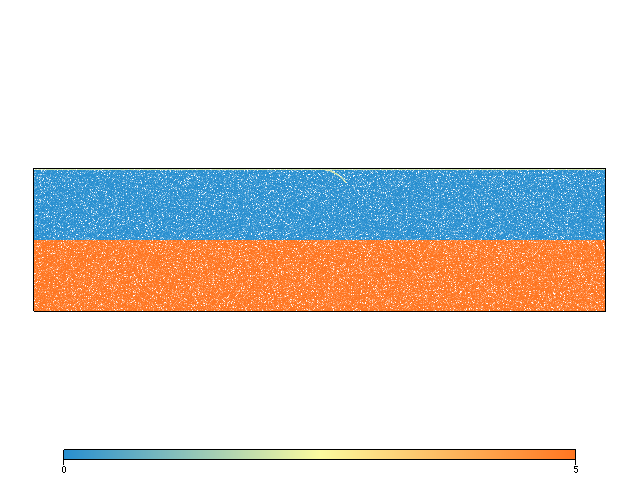

'test.gldb'

In [33]:
fig= glucifer.Figure()
#fig.append( glucifer.objects.Points(gSwarm,tracerVariable, colours= 'white black'))
fig.append( glucifer.objects.Points(gSwarm,materialVariable))
#fig.append( glucifer.objects.Surface(mesh, dummyField))
fig.show()
fig.save_database('test.gldb')

Set up material parameters and functions
-----

Setup the viscosity to be a function of the temperature. Recall that these functions and values are preserved for the entire simulation time. 

In [34]:
# The yeilding of the upper slab is dependent on the strain rate.
strainRate_2ndInvariant = fn.tensor.second_invariant( 
                            fn.tensor.symmetric( 
                            velocityField.fn_gradient ))

gamma = dp.fc/(dp.a*dp.deltaT)

In [35]:
ndp.Wds, ndp.Wdf, ndp.Eds, ndp.Edf

(49.15683109565078, 17.875211307509375, 28.301795831549015, 19.75229500743525)

In [36]:
#ndp.Wds = 3.
#ndp.Wdf = 3.
#ndp.Eds = 11.
#ndp.Edf = 11.

In [37]:
ndp.n = 3.5

In [38]:
ndp.Wdf, ndp.Edf,ndp.eta_max

(17.875211307509375, 19.75229500743525, 100000.0)

In [39]:
############
#Rheology
#############
#
#The final mantle rheology is composed as follows*:
# 
#
# mantleviscosityFn = max{  min{(1/omega*Visc + 1/eta_p)**-1,
#                           eta_max},
#                           eta_min}
#                      
#Visc => min{diffusionCreep, dislocationCreep, }
#eta_p   => stress-limiting effective viscosity
#


omega = fn.misc.constant(1.)

if melt_viscosity_reduction:
    mvr =  fn.branching.conditional( [ (temperatureField > (ndp.Tmvp + 7.5*(1. - coordinate[1])) , 0.1 ),   (         True, 1.) ] )
    omega = omega*mvr


#implementation of the lower mantle viscosity increase, similar to Bello et al. 2015
a = 1.
B = 30.
d0 = 660e3/dp.LS  
ds = d0/10.
if lower_mantle:
    inner1 = 1. - 0.5*(1. - fn.math.tanh(((1. - d0)-(coordinate[1]))/(ds)))
    modfac = a*fn.math.exp(np.log(B)*inner1)
    omega = omega*modfac



##Diffusion Creep
ndfp = fn.misc.min(ndp.eta_max, fn.math.exp( ((ndp.Edf + (depthFn*ndp.Wdf))/((temperatureField + ndp.TS))) - 
              ((ndp.Edf + (ndp.Dr*ndp.Wdf))/((ndp.TPP + ndp.TS)))  ))



##Dislocation creep Creep
nl_correction = (strainRate_2ndInvariant/ndp.SR)**((1.-ndp.n)/(ndp.n))


ndsp = fn.misc.min(ndp.eta_max,(nl_correction)*fn.math.exp( ((ndp.Eds + (depthFn*ndp.Wds))/(dp.n*(temperatureField + ndp.TS))) -
                                     ((ndp.Eds + (ndp.Dr*ndp.Wds))/(dp.n*(ndp.TPP + ndp.TS)))))


Visc = fn.misc.min(ndp.eta_max, fn.misc.min(ndfp, ndsp))

ys =  ndp.cohesion + (depthFn*gamma*ndp.RA) #In this case we'll use a valid cohesion
yielding = ys/(strainRate_2ndInvariant/math.sqrt(0.5)) #extra factor to account for underworld second invariant form


linearVisc = fn.misc.min(ndp.eta_max, ndfp)

mantleviscosityFn = fn.misc.max(fn.misc.min(1./(((1./Visc) + (1./yielding))), ndp.eta_max), ndp.eta_min)



#lower mantle rheology

#ndflm = fn.misc.min(ndp.eta_max, fn.math.exp( ((ndp.Elm + (depthFn*ndp.Wlm))/((temperatureField + ndp.TS))) - 
#              ((ndp.Elm + (ndp.Dr*ndp.Wlm))/((ndp.TPP + ndp.TS)))  ))

#I ignored Cizkova's lower mantle diffusion creep parameters, 
#as they appeared to give lower values that the upper mantle rheology, i.e a visc. decrease at 660.
lm_increase = 10.
lowermantleviscosityFn = fn.misc.max(lm_increase*ndfp, ndp.eta_min)


##Crust rheology
reduceFac = 0.1
ysc =  reduceFac*ndp.cohesion + reduceFac*(depthFn*gamma*ndp.RA) #In this case we'll use a valid cohesion
crust_yielding = ysc/(strainRate_2ndInvariant/math.sqrt(0.5)) #extra factor to account for underworld second invariant form
crustviscosityFn = fn.misc.max(fn.misc.min(1./(((1./Visc) + (1./crust_yielding))), ndp.eta_max), ndp.eta_min)


In [40]:
ndp.Elm, ndp.Wlm

(11.79241492981209, 4.9156831095650784)


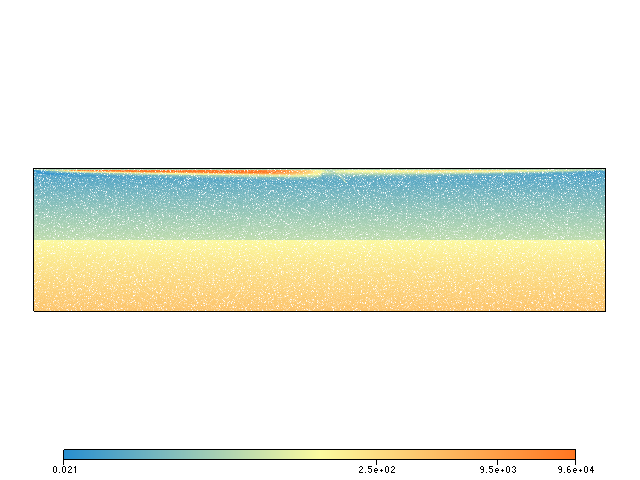

'test.gldb'

In [56]:
#fig= glucifer.Figure()
#fig.append( glucifer.objects.Points(gSwarm,tracerVariable, colours= 'white black'))
#fig.append( glucifer.objects.Points(gSwarm,viscosityMapFn, logScale=True))
#fig.append( glucifer.objects.Surface(mesh, temperatureField))

#fig.append( glucifer.objects.Surface(mesh,ndflm, logScale=True))
#fig.show()
#fig.save_database('test.gldb')

In [57]:
#fig= glucifer.Figure()
#fig.append( glucifer.objects.Points(gSwarm,tracerVariable, colours= 'white black'))
#fig.append( glucifer.objects.Points(gSwarm,materialVariable))
#fig.append( glucifer.objects.Surface(mesh, temperatureField))

#fig.append( glucifer.objects.Surface(mesh, strainRate_2ndInvariant/ndp.SR))
#fig.show()
#fig.save_database('test.gldb')

System setup
-----

Since we are using a previously constructed temperature field, we will use a single Stokes solve to get consistent velocity and pressure fields.

**Setup a Stokes system**

In [58]:
#this accounts for the decreas in expansivity
alphaRatio = 1.2/3
taFn = 1. - (1. - depthFn)*(1. - alphaRatio) 
raylieghFn = ndp.RA*temperatureField*taFn 


# Here we set a viscosity value of '1.' for both materials
viscosityMapFn = fn.branching.map( fn_key = materialVariable,
                         mapping = {lithosphereIndex:mantleviscosityFn, 
                                    crustIndex:ndp.eta_crust,
                                    mantleIndex:mantleviscosityFn,
                                    lowermantleIndex:lowermantleviscosityFn,
                                    eclIndex:mantleviscosityFn,
                                    airIndex:ndp.Steta0} )

densityMapFn = fn.branching.map( fn_key = materialVariable,
                         mapping = {airIndex:ndp.StRA, 
                                    lithosphereIndex:raylieghFn, 
                                    crustIndex:raylieghFn, 
                                    mantleIndex:raylieghFn,
                                   lowermantleIndex:raylieghFn} )

In [59]:

# Define our vertical unit vector using a python tuple (this will be automatically converted to a function).
gravity = ( 0.0, 1.0 )

# Now create a buoyancy force vector using the density and the vertical unit vector. 
buoyancyFn = densityMapFn * gravity

In [60]:
stokesPIC = uw.systems.Stokes(velocityField=velocityField, 
                              pressureField=pressureField,
                              conditions=[freeslipBC,],
                              fn_viscosity=linearVisc, 
                              fn_bodyforce=buoyancyFn )

**Set up and solve the Stokes system**

In [61]:
solver = uw.systems.Solver(stokesPIC)
if not checkpointLoad:
    solver.solve() #A solve on the linear visocisty is unhelpful unless we're starting from scratch

**Add the non-linear viscosity to the Stokes system**


In [62]:
stokesPIC.fn_viscosity = viscosityMapFn

In [63]:
solver.set_inner_method("mumps")
solver.options.scr.ksp_type="cg"
solver.set_penalty(1.0e7)
solver.options.scr.ksp_rtol = 1.0e-4
solver.solve(nonLinearIterate=True)
solver.print_stats()


 
Pressure iterations:   4
Velocity iterations:   1 (presolve)      
Velocity iterations:  -1 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:   1 (total solve)   
 
SCR RHS  solve time: 3.5640e-01
Pressure solve time: 4.2731e-02
Velocity solve time: 3.5258e-01 (backsolve)
Total solve time   : 8.1252e-01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 



**Create an advective diffusive system**

In [ ]:
advDiff = uw.systems.AdvectionDiffusion( phiField       = temperatureField, 
                                         phiDotField    = temperatureDotField, 
                                         velocityField  = velocityField,
                                         fn_sourceTerm    = 0.0,
                                         fn_diffusivity = 1.0, 
                                         #conditions     = [neumannTempBC, dirichTempBC] )
                                         conditions     = [ dirichTempBC] )

passiveadvector = uw.systems.SwarmAdvector( swarm         = gSwarm, 
                                     velocityField = velocityField, 
                                     order         = 1)

In [ ]:
population_control = uw.swarm.PopulationControl(gSwarm,deleteThreshold=0.2,splitThreshold=1.,maxDeletions=3,maxSplits=0, aggressive=True, particlesPerCell=ppc)

Analysis tools
-----

In [ ]:
#These are functions we can use to evuate integrals over restricted parts of the domain
# For instance, we can exclude the thermal lithosphere from integrals

def temprestrictionFn(lithval = 0.9):

    tempMM = fn.view.min_max(temperatureField)
    tempMM.evaluate(mesh)
    TMAX = tempMM.max_global()
    mantleconditions = [ (                                  temperatureField > lithval*TMAX, 1.),
                   (                                                   True , 0.) ]


    return fn.branching.conditional(mantleconditions)

mantlerestrictFn = temprestrictionFn(lithval = 0.85)



def platenessFn(val = 0.1):
    normgradV = fn.math.abs(velocityField.fn_gradient[0]/fn.math.sqrt(velocityField[0]*velocityField[0])) #[du*/dx]/sqrt(u*u)



    srconditions = [ (                                  normgradV < val, 1.),
                   (                                                   True , 0.) ]


    return fn.branching.conditional(srconditions)

srrestrictFn = platenessFn(val = 0.1)

In [ ]:
fig = glucifer.Figure()
fig.append( glucifer.objects.Surface(mesh, temperatureField) )

fig.show()
#fig.save_database('test.gldb')

In [ ]:
#Setup volume integrals 

tempint = uw.utils.Integral( temperatureField, mesh )
areaint = uw.utils.Integral( 1.,               mesh )

v2int   = uw.utils.Integral( fn.math.dot(velocityField,velocityField), mesh )

dwint   = uw.utils.Integral( temperatureField*velocityField[1], mesh )

sinner = fn.math.dot( strainRate_2ndInvariant, strainRate_2ndInvariant )
vdint = uw.utils.Integral( (4.*viscosityMapFn*sinner), mesh )

mantleArea   = uw.utils.Integral( mantlerestrictFn, mesh )
mantleTemp = uw.utils.Integral( temperatureField*mantlerestrictFn, mesh )
mantleVisc = uw.utils.Integral( mantleviscosityFn*mantlerestrictFn, mesh )
mantleVd = uw.utils.Integral( (4.*viscosityMapFn*sinner*mantlerestrictFn), mesh ) #these now work on MappingFunctions

In [ ]:
#Setup surface integrals

rmsSurfInt = uw.utils.Integral( fn=velocityField[0]*velocityField[0], mesh=mesh, integrationType='Surface', 
                          surfaceIndexSet=mesh.specialSets["MaxJ_VertexSet"])
nuTop      = uw.utils.Integral( fn=temperatureField.fn_gradient[1],    mesh=mesh, integrationType='Surface', 
                          surfaceIndexSet=mesh.specialSets["MaxJ_VertexSet"])
nuBottom   = uw.utils.Integral( fn=temperatureField.fn_gradient[1],    mesh=mesh, integrationType='Surface', 
                          surfaceIndexSet=mesh.specialSets["MinJ_VertexSet"])

plateint  = uw.utils.Integral( fn=srrestrictFn, mesh=mesh, integrationType='Surface', #Integrate the plateness function
                          surfaceIndexSet=mesh.specialSets["MaxJ_VertexSet"]) 

surfint  = uw.utils.Integral( fn=1., mesh=mesh, integrationType='Surface',   #Surface length function (i.e. domain width)
                          surfaceIndexSet=mesh.specialSets["MaxJ_VertexSet"])

In [ ]:
#Define functions for the evaluation of integrals

def basic_int(ourIntegral):           #This one just hands back the evaluated integral
    return ourIntegral.evaluate()[0]

def avg_temp():
    return tempint.evaluate()[0]/areaint.evaluate()[0]

def nusseltTB(temp_field, mesh):
    return -nuTop.evaluate()[0], -nuBottom.evaluate()[0]

def rms():
    return math.sqrt(v2int.evaluate()[0]/areaint.evaluate()[0])

def rms_surf():
    return math.sqrt(rmsSurfInt.evaluate()[0])

def max_vx_surf(velfield, mesh):
    vuvelxfn = fn.view.min_max(velfield[0])
    vuvelxfn.evaluate(mesh.specialSets["MaxJ_VertexSet"])
    return vuvelxfn.max_global()


def visc_extr(viscfn):
    vuviscfn = fn.view.min_max(viscfn)
    vuviscfn.evaluate(mesh)
    return vuviscfn.max_global(), vuviscfn.min_global()

In [ ]:
#v2sum_integral  = uw.utils.Integral( mesh=mesh, fn=fn.math.dot( velocityField, velocityField ) )
#volume_integral = uw.utils.Integral( mesh=mesh, fn=1. )
#Vrms = math.sqrt( v2sum_integral.evaluate()[0] )/volume_integral.evaluate()[0]



#if(uw.rank()==0):
#    print('Initial Vrms = {0:.3f}'.format(Vrms))

In [ ]:
# Check the Metrics

#Avg_temp = avg_temp()
#Rms = rms()
#Rms_surf = rms_surf()
#Max_vx_surf = max_vx_surf(velocityField, mesh)
#Gravwork = basic_int(dwint)
#Viscdis = basic_int(vdint)
#nu1, nu0 = nusseltTB(temperatureField, mesh) # return top then bottom
#etamax, etamin = visc_extr(mantleviscosityFn)

Area_mantle = basic_int(mantleArea)
#Viscmantle = basic_int(mantleVisc)
#Tempmantle = basic_int(mantleTemp)
#Viscdismantle = basic_int(mantleVd)

In [ ]:
#Tempmantle/Area_mantle, Viscmantle/Area_mantle
#Plateness = basic_int(plateint)/basic_int(surfint)

In [ ]:
Area_mantle

Viz.
-----

In [ ]:
viscVariable = gSwarm.add_variable( dataType="float", count=1 )
viscVariable.data[:] = viscosityMapFn.evaluate(gSwarm)

In [ ]:
#Pack some stuff into a database as well
figDb = glucifer.Figure()
#figDb.append( glucifer.objects.Mesh(mesh))
figDb.append( glucifer.objects.VectorArrows(mesh,velocityField, scaling=0.0005))
figDb.append( glucifer.objects.Points(gSwarm,tracerVariable, colours= 'white black'))
figDb.append( glucifer.objects.Points(gSwarm,viscosityMapFn, logScale=True))
figDb.append( glucifer.objects.Surface(mesh, strainRate_2ndInvariant, logScale=True))
figDb.append( glucifer.objects.Surface(mesh, temperatureField))
#figDb.show()

In [ ]:
#figDb.show()


In [ ]:
velocityField.data[iWalls.data][np.where(velocityField.data[iWalls.data] == 0)]

In [ ]:

def checkpoint1(step, checkpointPath,filename, filewrites):
    path = checkpointPath + str(step) 
    os.mkdir(path)
    ##Write and save the file, if not already a writing step
    if not step % filewrites == 0:
        filename.write((17*'%-15s ' + '\n') % (realtime, Viscdis, float(nu0), float(nu1), Avg_temp,
                                              Tempmantle,TMAX,
                                              Rms,Rms_surf,Max_vx_surf,Gravwork, etamax, etamin, 
                                              Area_mantle, Viscmantle,  Viscdismantle,Plateness ))
    filename.close()
    shutil.copyfile(os.path.join(outputPath, outputFile), os.path.join(path, outputFile))


def checkpoint2(step, checkpointPath, swarm, filename, varlist = [materialVariable], varnames = ['materialVariable']):
    path = checkpointPath + str(step) 
    velfile = "velocityField" + ".hdf5"
    tempfile = "temperatureField" + ".hdf5"
    pressfile = "pressureField" + ".hdf5"
    velocityField.save(os.path.join(path, velfile))
    temperatureField.save(os.path.join(path, tempfile))
    pressureField.save(os.path.join(path, pressfile))
    swarm.save(os.path.join(path, "swarm.h5") ) 
    for ix in range(len(varlist)):
        varb = varlist[ix]
        varb.save(os.path.join(path,varnames[ix] + ".h5"))
    

**Miscellania**

In [ ]:
surface_xs = np.linspace(mesh.minCoord[0], mesh.maxCoord[0], mesh.elementRes[0] + 1)
surface_nodes = np.array(zip(surface_xs, np.ones(len(surface_xs)*mesh.maxCoord[1]))) #For evaluation surface velocity


normgradV = velocityField.fn_gradient[0]/fn.math.sqrt(velocityField[0]*velocityField[0])

tempMM = fn.view.min_max(temperatureField)
dummy = tempMM.evaluate(mesh)



In [ ]:
tempMM.max_global(), temperatureField.data.max()

Main simulation loop
-----

Run a few advection and Stokes solver steps to make sure we are in, or close to, equilibrium.

In [ ]:
# initialise timer for computation
start = time.clock()
# setup summary output file (name above)
if checkpointLoad:
    if uw.rank() == 0:
        shutil.copyfile(os.path.join(checkpointLoadDir, outputFile), outputPath+outputFile)
    comm.Barrier()
    f_o = open(os.path.join(outputPath, outputFile), 'a')
    prevdata = np.genfromtxt(os.path.join(outputPath, outputFile), skip_header=0, skip_footer=0)
    if len(prevdata.shape) == 1: #this is in case there is only one line in previous file
        realtime = prevdata[0]
    else:
        realtime = prevdata[prevdata.shape[0]-1, 0]
    step = int(checkpointLoadDir.split('/')[-1])
    timevals = [0.]
else:
    f_o = open(outputPath+outputFile, 'w')
    realtime = 0.
    step = 0
    timevals = [0.]

In [ ]:
#while step < 21:
while realtime < 1.:

    # solve Stokes and advection systems
    solver.solve(nonLinearIterate=True)
    dt = advDiff.get_max_dt()
    if step == 0:
        dt = 0.
    advDiff.integrate(dt)
    passiveadvector.integrate(dt)
    
    #Add the adiabatic adjustment:
    temperatureField.data[:] += dt*abHeatFn.evaluate(mesh)
    

    # Increment
    realtime += dt
    step += 1
    timevals.append(realtime)
    ################
    #Update temperature field in the air region
    #Do this better...
    ################
    if (step % sticky_air_temp == 0):
        for index, coord in enumerate(mesh.data):
            if coord[1] >= 1.:
                temperatureField.data[index] = ndp.TSP
    ################
    #Gldb output
    ################ 
    if (step % gldbs_output == 0):
        #Rebuild any necessary swarm variables
        viscVariable.data[:] = viscosityMapFn.evaluate(gSwarm)
        #Write gldbs
        fnamedb = "dbFig" + "_" + str(ModIt) + "_" + str(step) + ".gldb"
        fullpath = os.path.join(outputPath + "gldbs/" + fnamedb)
        #figDb.show()
        figDb.save_database(fullpath)
    ################
    #Files output
    ################ 
    if (step % files_output == 0):

        vel_surface = velocityField.evaluate_global(surface_nodes)
        norm_surface_sr = normgradV.evaluate_global(surface_nodes)
        if uw.rank() == 0:
            fnametemp = "velsurface" + "_" + str(ModIt) + "_" + str(step)
            fullpath = os.path.join(outputPath + "files/" + fnametemp)
            np.save(fullpath, vel_surface)
            fnametemp = "norm_surface_sr" + "_" + str(ModIt) + "_" + str(step)
            fullpath = os.path.join(outputPath + "files/" + fnametemp)
            np.save(fullpath, norm_surface_sr)
    ################            
    # Calculate the Metrics, only on 1 of the processors:
    ################
    if (step % metric_output == 0):
        ###############
        #Swarm - based Metrics
        ###############
        # Calculate the RMS velocity and Nusselt number.
        # Calculate the Metrics, only on 1 of the processors:
        mantlerestrictFn = temprestrictionFn() #rebuild the mantle restriction function (but these should be dynamic?)
        srrestrictFn = platenessFn(val = 0.1) #rebuild the plateness restriction function
        dummy = tempMM.evaluate(mesh) #Re-evaluate any fn.view.min_max guys
        #Rebuild these integrals (a test because metrics changes after a restart)
        mantleArea   = uw.utils.Integral( mantlerestrictFn, mesh )
        mantleTemp = uw.utils.Integral( temperatureField*mantlerestrictFn, mesh )
        mantleVisc = uw.utils.Integral( mantleviscosityFn*mantlerestrictFn, mesh )
        mantleVd = uw.utils.Integral( (4.*viscosityMapFn*sinner*mantlerestrictFn), mesh ) #these now work on MappingFunctions
        ###
        Avg_temp = avg_temp()
        Rms = rms()
        Rms_surf = rms_surf()
        Max_vx_surf = max_vx_surf(velocityField, mesh)
        Gravwork = basic_int(dwint)
        Viscdis = basic_int(vdint)
        nu1, nu0 = nusseltTB(temperatureField, mesh) # return top then bottom
        etamax, etamin = visc_extr(mantleviscosityFn)
        Area_mantle = basic_int(mantleArea)
        Viscmantle = basic_int(mantleVisc)
        Tempmantle = basic_int(mantleTemp)
        Viscdismantle = basic_int(mantleVd)
        Plateness = basic_int(plateint)/basic_int(surfint)
        TMAX = tempMM.max_global()
        # output to summary text file
        if uw.rank()==0:
            f_o.write((17*'%-15s ' + '\n') % (realtime, Viscdis, float(nu0), float(nu1), Avg_temp,
                                              Tempmantle,TMAX,
                                              Rms,Rms_surf,Max_vx_surf,Gravwork, etamax, etamin, 
                                              Area_mantle, Viscmantle,  Viscdismantle,Plateness ))
    ################
    #Also repopulate entire swarm periodically
    ################
    #if step % swarm_repop == 0:
    population_control.repopulate()
    
    ################
    #Checkpoint
    ################
    if step % checkpoint_every == 0:
        if uw.rank() == 0:
            checkpoint1(step, checkpointPath,f_o, metric_output)           
        checkpoint2(step, checkpointPath, gSwarm, f_o, varlist = varlist, varnames = varnames)
        f_o = open(os.path.join(outputPath, outputFile), 'a') #is this line supposed to be here?
    ################
    #Particle update
    ###############
    timeVariable.data[:] += dt #increment the ages (is this efficient?)
    dummyData = np.copy(materialVariable.data)#This is part of a hack that resets ages when a material type changes
    if step % swarm_update == 0:
        for i in range(2): #Need to go through twice first time through
            materialVariable.data[:] = fn.branching.conditional(DG.condition_list).evaluate(gSwarm)
    timeVariable.data[np.where(dummyData[:] != materialVariable.data[:])] = 0. #resets those ages when a material type change
    
f_o.close()
print 'step =',step

In [109]:
viscVariable = gSwarm.add_variable( dataType="float", count=1 )
viscVariable.data[:] = viscosityMapFn.evaluate(gSwarm)

RuntimeError: Function input dimensionality (2) does not appear to match mesh variable dimensionality (105).

In [34]:
figSwarm = glucifer.Figure(figsize=(1024,384))
#figSwarm.append( glucifer.objects.Points(gSwarm,viscVariable, logScale=True))
figSwarm.append( glucifer.objects.Mesh(mesh))
figSwarm.show()
figSwarm.save_database('test.gldb')

NameError: name 'gSwarm' is not defined

In [105]:
#velocityField.data[iWalls.data]


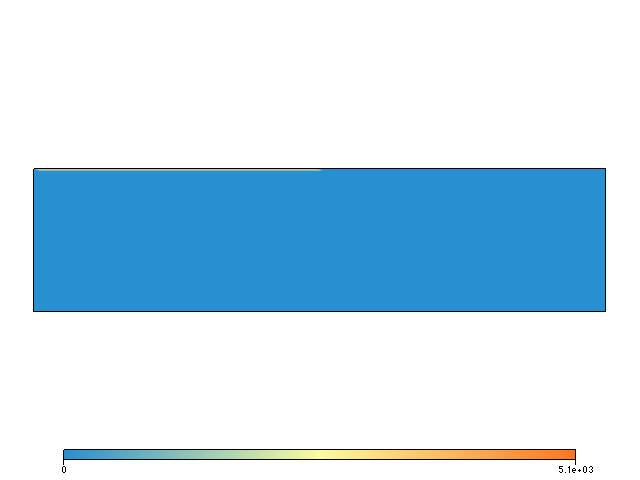

In [28]:
#Pack some stuff into a database as well
figDb = glucifer.Figure()
#figDb.append( glucifer.objects.Mesh(mesh))
figDb.append( glucifer.objects.VectorArrows(mesh,velocityField))
#figDb.append( glucifer.objects.Points(gSwarm,tracerVariable, colours= 'white black'))
#figDb.append( glucifer.objects.Points(gSwarm,viscVariable, logScale=True))
#figDb.append( glucifer.objects.Surface(mesh, mantleviscosityFn, logScale=True))
figDb.append( glucifer.objects.Surface(mesh, velocityField[0]))
figDb.show()

In [37]:
velocityField.data.max()

5070.202342530959